# Model 2a - kNNRegressor with standardization & PCA

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from openpyxl import load_workbook

In [2]:
# get data
parentdir = os.path.dirname(os.getcwd())
data = pd.read_excel(parentdir+'\\Data\\SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),Trend Line of Intersection (°),Length Line of Intersection (m),Plunge Line of Intersection Basal-Joint1 (°),Trend Line of Intersection Basal-Joint1 (°),Length Line of Intersection Basal-Joint1 (m),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,6349.248707,171.429715,31.846178,161.418240,56.856884,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,7701.148241,207.931003,31.905513,168.542870,56.762278,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,2341.641868,63.224330,36.973415,150.874977,49.879923,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,155.345062,4.194317,54.969435,195.219985,36.636928,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,7468.340623,201.645197,29.688564,178.765625,60.571151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 87)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Safety Factor","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
print(np.shape(data_model))
data_model.head()

(5000, 9)


,Safety Factor,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Friction Angle of Joint 2 (°)
0,1.082239,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,29.522638
1,1.203906,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,29.079492
2,0.896601,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,27.455866
3,0.680996,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,34.401616
4,1.263948,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,28.613525


In [5]:
# remove any realizations that are not kinematically possible and any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 9)


## Learning curves for different train_test_split random_states

Variable random_state (=0, 1, 42, 123) for train_test_split.

In [6]:
num_samples = []

r2_train_subsample_list = []
rmse_train_subsample_list = []
r2_test_subsample_list = []
rmse_test_subsample_list = []

random_state_val = [0,1,42,123]

for x in range(0,4):

    # dataset up to 4950 data points
    for i in range(100, 5000, 50):

        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)
        fos_outliers = data_subsample[data_subsample['Safety Factor']>3]
        num_outliers.append(len(fos_outliers.index))
        
        # train/test split with different random_state values (0, 1, 42, and 123)
        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_train_subsample = train_subsample[["Safety Factor"]]
        y_train_subsample = np.ravel(y_train_subsample)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_test_subsample = test_subsample[["Safety Factor"]]
        y_test_subsample = np.ravel(y_test_subsample)

        # train basic knn model with default hyperparameters
        # use first 6 PCs as input into model (refer to PCA.ipynb for how the number 6 was chosen)
        # make pipeline for knn with pre-processing (standardizing the data)
        pipe_knn = make_pipeline(StandardScaler(), PCA(n_components=6), KNeighborsRegressor())
        pipe_knn.fit(x_train_subsample, y_train_subsample)

        ypred_knn = pipe_knn.predict(x_train_subsample)
        ypred_knn = np.reshape(ypred_knn,(len(ypred_knn),1))

        # training r2 and rmse
        r2_train_subsample = pipe_knn.score(x_train_subsample,y_train_subsample)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_knn))

        # append training r2 and rmse to their respective lists
        r2_train_subsample_list.append(r2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)

        # test the knn model
        # predict y test
        ypred_test_knn = pipe_knn.predict(x_test_subsample)
        ypred_test_knn = np.reshape(ypred_test_knn,(len(ypred_test_knn),1))

        # test r2 and rmse
        r2_test_subsample = pipe_knn.score(x_test_subsample,y_test_subsample)
        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_knn))

        # append testing r2 and rmse to their respective lists
        r2_test_subsample_list.append(r2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
        
    # entire dataset (4992 data points)
    num_samples.append(len(data_model.index))

    # get subsample of data
    data_subsample = data_model.sample(n = len(data_model.index),random_state = 1)

    # train/test split with different random_state values (0, 1, 42, and 123)
    train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

    x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_train_subsample = train_subsample[["Safety Factor"]]
    y_train_subsample = np.ravel(y_train_subsample)

    x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_test_subsample = test_subsample[["Safety Factor"]]
    y_test_subsample = np.ravel(y_test_subsample)

    # train basic knn model with default hyperparameters
    # use first 6 PCs as input into model (refer to PCA.ipynb for how the number 6 was chosen)
    # make pipeline for knn with pre-processing (standardizing the data)
    pipe_knn = make_pipeline(StandardScaler(), PCA(n_components=6), KNeighborsRegressor())
    pipe_knn.fit(x_train_subsample, y_train_subsample)

    ypred_knn = pipe_knn.predict(x_train_subsample)
    ypred_knn = np.reshape(ypred_knn,(len(ypred_knn),1))

    # training r2 and rmse
    r2_train_subsample = pipe_knn.score(x_train_subsample,y_train_subsample)
    rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_knn))

    # append training r2 and rmse to their respective lists
    r2_train_subsample_list.append(r2_train_subsample)
    rmse_train_subsample_list.append(rmse_train_subsample)

    # test the knn model
    # predict y test
    ypred_test_knn = pipe_knn.predict(x_test_subsample)
    ypred_test_knn = np.reshape(ypred_test_knn,(len(ypred_test_knn),1))

    # test r2 and rmse
    r2_test_subsample = pipe_knn.score(x_test_subsample,y_test_subsample)
    rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_knn))

    # append testing r2 and rmse to their respective lists
    r2_test_subsample_list.append(r2_test_subsample)
    rmse_test_subsample_list.append(rmse_test_subsample)

In [7]:
# transform lists of results into dataframes
num_samples = pd.DataFrame(num_samples)

r2_train_subsample_list = pd.DataFrame(r2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
r2_test_subsample_list = pd.DataFrame(r2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)

In [8]:
# concatenate dataframes into one result dataframe
rslts = pd.concat([num_samples,r2_train_subsample_list,rmse_train_subsample_list,r2_test_subsample_list,rmse_test_subsample_list],axis=1)

In [9]:
# divide the rslts dataframe by the random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

,0,0,0,0,0,0,0,0
391,4800,35,0.756770,0.264727,0.113289,0.731273,0.219522,0.129800
392,4850,36,0.842377,0.207479,0.066866,0.695907,0.272877,0.080978
393,4900,36,0.619233,0.314873,0.162452,0.449683,0.398729,0.197296
394,4950,36,0.811664,0.226255,0.077045,0.769737,0.233092,0.094456
395,4992,37,0.734080,0.272774,0.117029,0.659582,0.266821,0.138439


In [10]:
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','r2_train_subsample','rmse_train_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','r2_train_subsample','rmse_train_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','r2_train_subsample','rmse_train_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','r2_train_subsample','rmse_train_subsample','r2_test_subsample','rmse_test_subsample'])


([<matplotlib.axis.XTick at 0x191b47cba00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

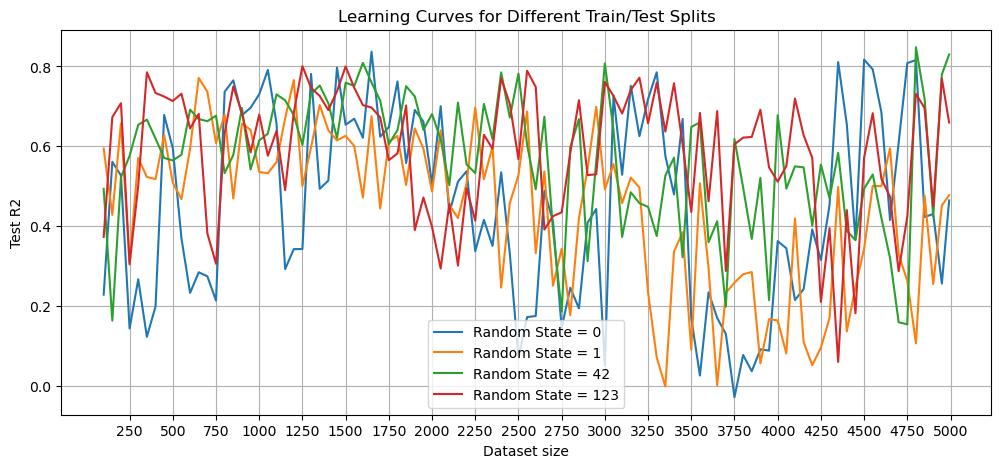

In [12]:
# plot learning curves for different train/test splits for test R2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['R2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['R2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['R2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['R2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])
#plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x191b956b610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

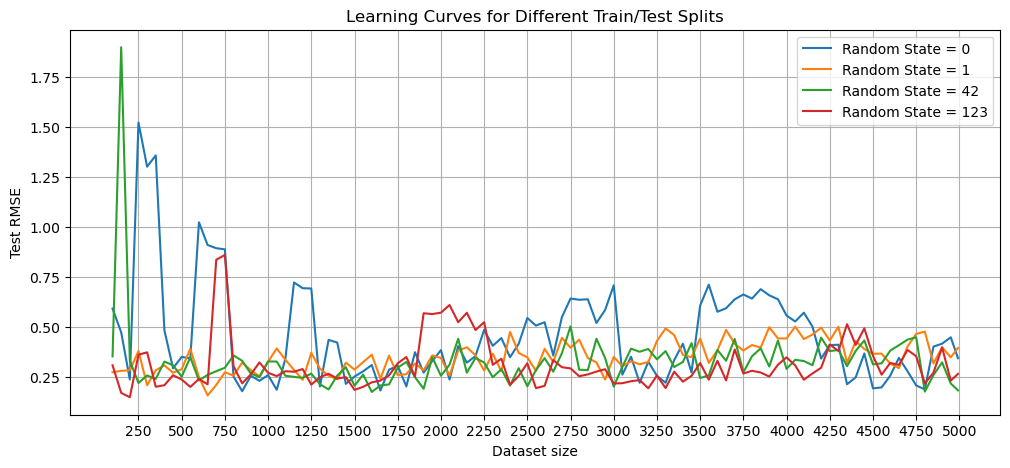

In [13]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [14]:
# train R2 - test R2
randomstate0_R2diff = randomstate0_rslts_pd['R2_train_subsample'] - randomstate0_rslts_pd['R2_test_subsample']
randomstate1_R2diff = randomstate1_rslts_pd['R2_train_subsample'] - randomstate1_rslts_pd['R2_test_subsample']
randomstate42_R2diff = randomstate42_rslts_pd['R2_train_subsample'] - randomstate42_rslts_pd['R2_test_subsample']
randomstate123_R2diff = randomstate123_rslts_pd['R2_train_subsample'] - randomstate123_rslts_pd['R2_test_subsample']

# test RMSE - train RMSE
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']



([<matplotlib.axis.XTick at 0x191ba6679d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

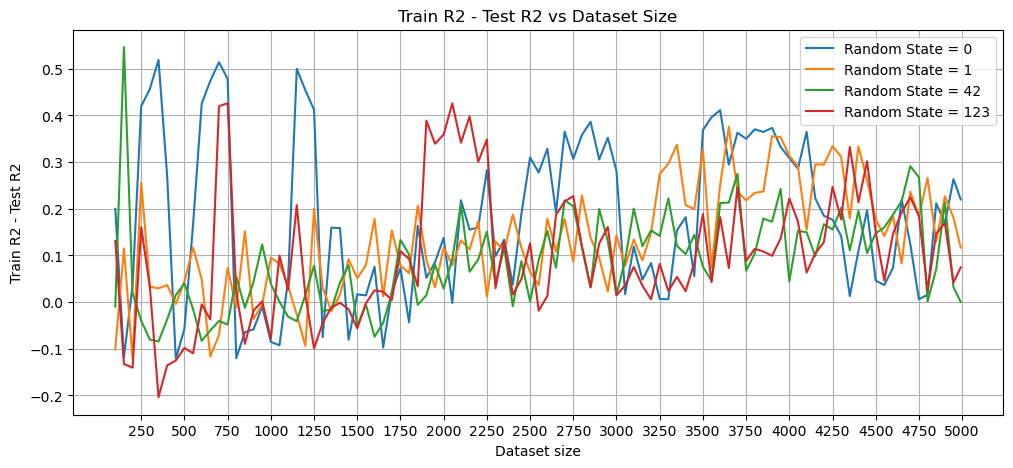

In [15]:
# plot R2 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_R2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_R2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_R2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_R2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x191ba6ed5e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

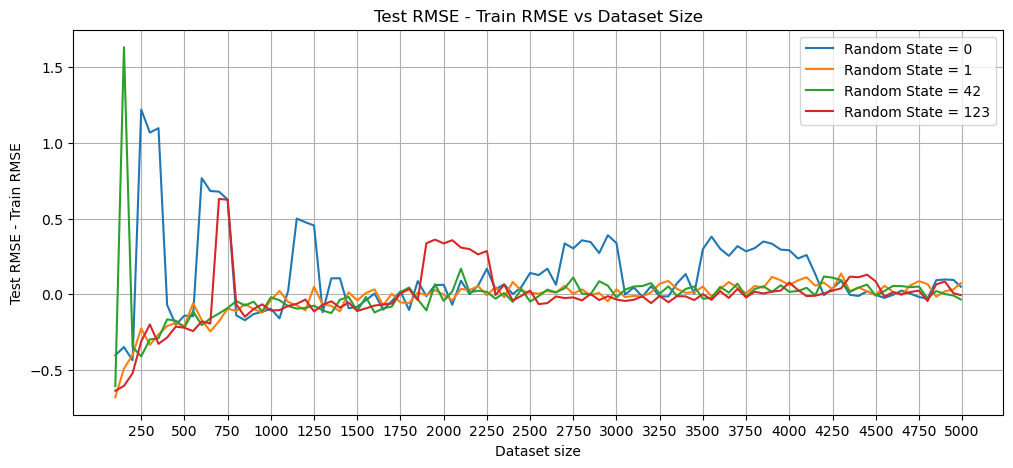

In [16]:
# plot rmse diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [17]:
# concatenate results for each random_state value into one dataframe for output into Excel
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)

,num_samples,num_outliers,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample,num_samples,num_outliers,...,rmse_test_subsample,mape_test_subsample,num_samples,num_outliers,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample
0,100.0,2.0,0.429033,0.995715,0.167293,0.229117,0.592445,0.259253,100.0,2.0,...,0.353860,0.195886,100.0,2.0,0.504822,0.947483,0.143615,0.373646,0.309652,0.195764
1,150.0,3.0,0.443055,0.822753,0.163156,0.561488,0.473950,0.235920,150.0,3.0,...,1.896416,0.202125,150.0,3.0,0.540377,0.777965,0.120269,0.673074,0.172000,0.110943
2,200.0,3.0,0.563939,0.674645,0.113539,0.527113,0.238490,0.151127,200.0,3.0,...,0.332292,0.222150,200.0,3.0,0.567576,0.672988,0.115104,0.707997,0.150307,0.106813
3,250.0,3.0,0.564668,0.300694,0.193203,0.144553,1.520717,0.234740,250.0,3.0,...,0.221465,0.187291,250.0,3.0,0.465077,0.673975,0.186605,0.304979,0.362348,0.273849
4,300.0,3.0,0.724120,0.232559,0.141137,0.267472,1.300409,0.226616,300.0,3.0,...,0.258944,0.168674,300.0,3.0,0.534996,0.573924,0.152250,0.502207,0.374412,0.188221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,4800.0,35.0,0.831500,0.218947,0.077571,0.815798,0.189320,0.097628,4800.0,35.0,...,0.178376,0.084256,4800.0,35.0,0.756770,0.264727,0.113289,0.731273,0.219522,0.129800
95,4850.0,36.0,0.635097,0.310407,0.153895,0.423331,0.402882,0.189484,4850.0,36.0,...,0.260894,0.119530,4850.0,36.0,0.842377,0.207479,0.066866,0.695907,0.272877,0.080978
96,4900.0,36.0,0.600060,0.319894,0.160690,0.430895,0.417503,0.204073,4900.0,36.0,...,0.324068,0.196254,4900.0,36.0,0.619233,0.314873,0.162452,0.449683,0.398729,0.197296
97,4950.0,36.0,0.520246,0.354917,0.180473,0.256730,0.449192,0.229559,4950.0,36.0,...,0.219066,0.107577,4950.0,36.0,0.811664,0.226255,0.077045,0.769737,0.233092,0.094456


In [18]:
# output results to Excel
book = load_workbook(parentdir+'\\ML Models Results\\Model2a_Results.xlsx')
writer = pd.ExcelWriter(parentdir+'\\ML Models Results\\Model2a_Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'FORMATTED')
writer.save()
writer.close()